In [6]:
import Base.isless
import Dates

import CSV
import DataFrames

using Plots

mutable struct Limit
    ts::Dates.DateTime
    price::Float64
    volume::Float64
end

mutable struct Orderbook
    bids::Array{Limit, 1}
    asks::Array{Limit, 1}
end

In [10]:
data = CSV.read("./data/csv/gdax_ETH-USD.dtf.csv", header=[:ts, :seq, :is_trade, :is_bid, :price, :volume], types=[Union{i, Missing} for i in [Float64, UInt64, Bool, Bool, Float64, Float64]]);
sort!(data, (:ts));
data[:ts] = Dates.unix2datetime.(data[:ts]);

In [13]:
trades = data[data[:is_trade] .== true, :];
limit_orders = data[data[:is_trade] .== false, :];

In [37]:
@inline function isless(itm_1::Limit, itm_2::Limit)::Bool
    # Function is required to sort Limit items
    return itm_1.price < itm_2.price
end

function create_simple_orderbook(df::DataFrames.DataFrame, current_orderbook::Union{Orderbook, Nothing}=nothing, cb::Union{Function, Nothing}=nothing,
                          mut_vector::Union{Array{Any}, Nothing}=nothing, pass_order::Bool=true)::Orderbook
    # Takes orderbook deltas and converts it into a simple orderbook. Orders are not kept in a queue to keep track
    # of order priority. That will come in the future. TODO
    
    # Orderbook information is contained as book deltas with the following headers:
    #     :ts, :seq, :is_trade, :is_bid, :price, :volume
    #
    #
    # Argument Descriptions
    # `df`: Orderbook deltas with headers [:ts, :seq, :is_trade, :is_bid, :price, :volume]
    #
    # `cb`: Callback function called each delta. The state of the orderbook will be passed
    #       to the callback for computing values. Five arguments are passed into the callback.
    #       In order, they are: f(book::Orderbook, vec::Union{Array{Any}, Nothing}, order::DataFrames.DataFrameRow, ret_value::Bool=false)
    #
    # `mut_vector`: Vector to insert callback result values. Mutates the vector passed to the function.
    #               If a callback is supplied but no vector is passed, the callback is skipped.
    #
    # `ret_ts`: Boolean value that determines whether to pass the current delta/order into the callback.
    #           A side effect of setting this value to `true` is that the `mut_vector` will contain
    #           a timestamp prepended to each value pushed to `mut_vector` as a matrix.
    
    bids = Dict{Float64, Limit}()
    asks = Dict{Float64, Limit}()
    
    if current_orderbook != nothing
        bids = Dict{Float64, Limit}(zip([delta.price for delta in current_orderbook.bids], current_orderbook.bids))
        asks = Dict{Float64, Limit}(zip([delta.price for delta in current_orderbook.asks], current_orderbook.asks))
    end
    
    for delta in DataFrames.eachrow(df[df[:is_trade] .== false, :])
        # Set to nothing so that we can select a side and not have repeating code
        side = delta[:is_bid] ? bids : asks
        
        if delta[:volume] == 0.0
            # Delete entry if size == 0.00
            delete!(side, delta[:price])
        else
            # Update the price level to a new price
            side[delta[:price]] = Limit(delta[:ts], delta[:price], delta[:volume])
        end
        
        if cb != nothing && mut_vector != nothing && length(bids) > 0 && length(asks) > 0
            # Reverse bids to have the first index be the best bid.
            # We sort the orderbook as well so that we can compute depth appropriately, and have
            # levels in sequential order.
            
            # We optimized this section of code to use as few allocations as possible.
            # For maximum performance, ensure your callback is inlined.
            cb(Orderbook(
                    reverse(sort(collect(values(bids)))),
                    sort(collect(values(asks)))),
                
                mut_vector, 
                pass_order ? delta : nothing, 
                false)
        end
    end
    
    # Return sorted orderbook
    return Orderbook(
        reverse(sort(collect(values(bids)))), 
        sort(collect(values(asks))))
    
end

@inline function book(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                      order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true)
    # Returns the orderbook as is for further data analysis.
    # TODO: add timestamp if variable `order` is something
    if mut_vector != nothing
        push!(mut_vector, book)
    end
    
    if ret_val
        return book
    end
end

@inline function mid_price(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                           order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true)
    # Gets the mid price of the orderbook `book` at time `t`.
    # Mid price is defined as `(best_bid + best_ask) / 2`
    # Pushes Float64 value to mutable vector or 
    # [Dates.DateTime Float64] 1x2 matrix into the mutable vector
    
    mid_price = (book.asks[1].price + book.bids[1].price) / 2
    
    if mut_vector != nothing
        if order == nothing
            push!(mut_vector, mid_price)
        else
            push!(mut_vector, [order.ts mid_price])
        end
    end
    
    if ret_val
        if order == nothing
            return mid_price
        else
            return vcat([order[:ts] mid_price])
        end
    end
end

@inline function spread(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                        order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true)
    # Gets the spread of the orderbook `book` at time `t`.
    # Spread is defined as `best_ask - best_bid`
    # Pushes Float64 value to mutable vector or 
    # [Dates.DateTime Float64] 1x2 matrix into the mutable vector
    spread = book.asks[1].price - book.bids[1].price
    
    if mut_vector != nothing
        if order == nothing
            push!(mut_vector, spread)
        else
            push!(mut_vector, [order[:ts] spread])
        end
    end
    
    if ret_val
        if order == nothing
            return spread
        else
            return vcat([order[:ts] spread]...)
        end
    end
end

@inline function bid_relative_price_level(book::Orderbook, mut_vector::Union{Array{Any}, Nothing},
                                          order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                          level::Int64=1)
    
    # Gets the bid relative price at level `n`. Default is level=1
    if length(book.bids) > level
        if mut_vector != nothing
            if order == nothing
                push!(mut_vector, book.bids[1].price - book.bids[level].price)
            else
                push!(mut_vector, [order[:ts] book.bids[1].price - book.bids[level].price])
            end
        end

        if ret_val
            if order == nothing
                return book.bids[1].price - book.bids[level].price
            else
                return vcat([order[:ts] book.bids[1].price - book.bids[level].price])
            end
        end
    end
end

@inline function bid_relative_price(book::Orderbook, mut_vector::Union{Array{Any}, Nothing},
                                    order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                    price::Float64=1.0)
    
    # Gets the ask relative price at level `n`. Default is level=1
    for (level_index, level) in enumerate(book.bids)
        if level.price == price
            if mut_vector != nothing
                if order == nothing
                    push!(mut_vector, [level_index level.price])
                else
                    push!(mut_vector, [order[:ts] level_index level.price])
                end
            end
            
            if ret_val
                if order == nothing
                    return [level_index level.price]
                else
                    return [order[:ts] level_index level.price]
                end
            end
        
            break
            
        end
        
        if level_index == length(book.bids)
            println("Price $(price) not found in bids")
        end
    end
end

@inline function ask_relative_price(book::Orderbook, mut_vector::Union{Array{Any}, Nothing},
                                    order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                    price::Float64=1.0)
    
    for (level_index, level) in enumerate(book.asks)
        if level.price == price
            if mut_vector != nothing
                if order == nothing
                    push!(mut_vector, [level_index level.price])
                else
                    push!(mut_vector, [order[:ts] level_index level.price])
                end
            end
            
            if ret_val
                if order == nothing
                    return [level_index level.price]
                else
                    return [order[:ts] level_index level.price]
                end
            end
        
            break
            
        end
        
        if level_index == length(book.asks)
            println("Price $(price) not found in asks")
        end
    end
end

@inline function ask_relative_price_level(book::Orderbook, mut_vector::Union{Array{Any}, Nothing},
                                          order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                          level::Int64=1)

    if mut_vector != nothing
        if order == nothing
            push!(mut_vector, book.asks[level].price - book.asks[1].price)
        else
            push!(mut_vector, [order[:ts] book.asks[level].price - book.asks[1].price])
        end
    end
    
    if ret_val
        if order == nothing
            return book.asks[level].price - book.asks[1].price
        else
            return vcat([order[:ts] book.asks[level].price - book.asks[1].price])
        end
    end
end
    
@inline function depth(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                       order::Union{DataFrames.DataFrameRow, Nothing}=nothing, ret_val::Bool=true)
    
    bid_depth = vcat([[level.ts level.price level.volume] for level in book.bids]...)
    bid_depth[:, 3] = cumsum(bid_depth[:, 3])
    
    ask_depth = vcat([[level.ts level.price level.volume] for level in book.asks]...)
    ask_depth[:, 3] = cumsum(ask_depth[:, 3])

    if mut_vector != nothing
        if order == nothing
            push!(mut_vector, [bid_depth[:, 2:3], ask_depth[:, 2:3]])
        else
            push!(mut_vector, [bid_depth, ask_depth])
        end
    end
    
    if ret_val
        if order == nothing
            return [bid_depth[:, 2:3], ask_depth[:, 2:3]]
        else
            return [bid_depth, ask_depth]
        end
    end
end

function depth_at_level(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                                order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                level=1, bid=true)
    
    if bid
        if size(book.bids)[1] < level
            return
        end
        
        bid_depth = vcat([[level.ts level.price level.volume] for level in book.bids]...)
        bid_depth[:, 3] = cumsum(bid_depth[:, 3])
        
        if mut_vector != nothing
            if order == nothing
                push!(mut_vector, reshape(bid_depth[level, 2:3], :, 2))
            else
                push!(mut_vector, reshape(bid_depth[level, :], :, 3))
            end
        end
        
        if ret_val
            if order == nothing
                return reshape(bid_depth[level, 2:3], :, 2)
            else 
                return reshape(bid_depth[level, :], :, 3)
            end
        end
    else
        if size(book.asks)[1] < level
            return
        end
        
        ask_depth = vcat([[level.ts level.price level.volume] for level in book.asks]...)
        ask_depth[:, 3] = cumsum(ask_depth[:, 3])
        
        if order == nothing
            push!(mut_vector, reshape(ask_depth[level, 2:3], :, 2))
        else
            push!(mut_vector, reshape(ask_depth[level, :], :, 3))
        end
        
        if ret_val
            if order == nothing
                return reshape(ask_depth[level, 2:3], :, 2)
            else
                return reshape(ask_depth[level, :], :, 3)
            end
        end
    end
end

depth_at_level (generic function with 4 methods)

In [42]:
dennis = create_simple_orderbook(limit_orders);

Orderbook(Limit[Limit(2018-11-19T07:54:53.91, 159.63, 0.01), Limit(2018-11-19T17:50:51.474, 152.01, 34.45), Limit(2018-11-19T17:50:51.349, 152.0, 87.2344), Limit(2018-11-19T17:50:48.329, 151.95, 0.01), Limit(2018-11-19T17:50:51.332, 151.92, 0.5), Limit(2018-11-19T17:50:51.112, 151.9, 32.711), Limit(2018-11-19T17:50:32.145, 151.87, 7.2949), Limit(2018-11-19T17:50:26.658, 151.86, 77.153), Limit(2018-11-19T17:50:50.407, 151.85, 0.01), Limit(2018-11-19T17:50:01.907, 151.81, 0.5)  …  Limit(2018-11-16T15:57:24.3, 0.15, 1.19939e5), Limit(2018-11-19T10:35:13.134, 0.13, 52840.5), Limit(2018-11-19T16:09:55.859, 0.11, 2.11154e5), Limit(2018-11-19T12:38:33.473, 0.1, 7.30597e5), Limit(2018-11-18T20:04:36.429, 0.08, 18390.5), Limit(2018-11-18T20:04:15.552, 0.06, 29566.3), Limit(2018-11-19T00:11:21.851, 0.05, 77337.8), Limit(2018-11-19T12:38:22.782, 0.03, 41508.3), Limit(2018-11-19T17:02:21.379, 0.02, 1.55764e5), Limit(2018-11-19T17:02:31.243, 0.01, 5.33365e5)], Limit[Limit(2018-11-19T17:50:51.363, 1

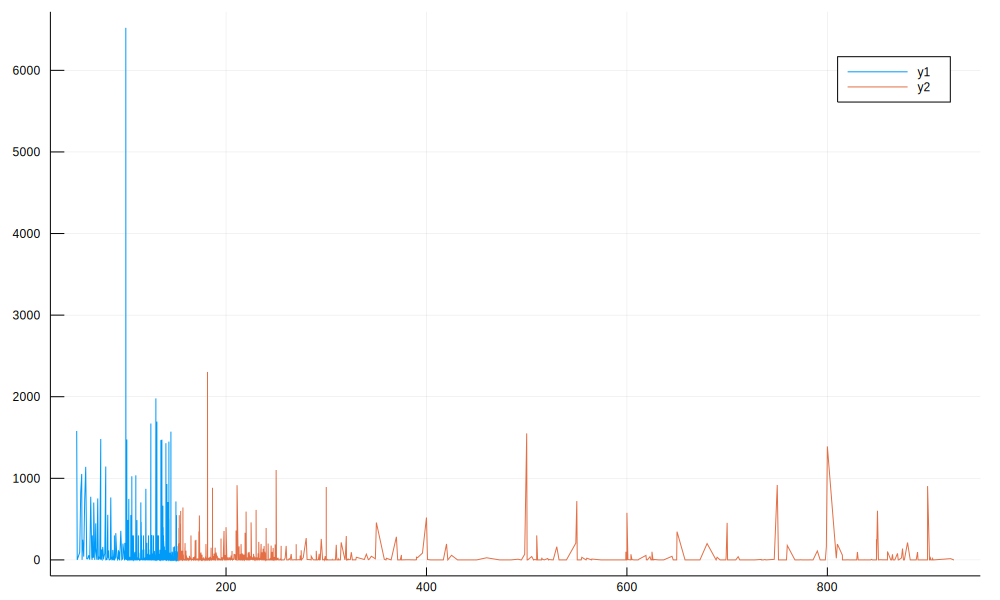

In [50]:
plot([x.price for x in dennis.bids[1:end-200]], [x.volume for x in dennis.bids[1:end-200]], size=(1000, 600))
plot!([x.price for x in dennis.asks[1:end-200]], [x.volume for x in dennis.asks[1:end-200]])